# Quantitative Trading Project Draft

<u>**By:**</u>

,,,,,





<u>**Date:**</u>

February 20, 2024

<u>**UChicago ID:**</u>

12408153,,,,,
***

## Imports
***

In [1]:
# Operating
import os
import shutil
import platform
import datetime

# Plotting
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

# Data
import statsmodels.api as sm
import pandas as pd
from pandas.plotting import scatter_matrix
import numpy as np
import scipy as sp
import quandl

# Typing
from typing import Union

# Displays
from IPython.display import display, Markdown
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Configuration
pd.set_option('display.float_format', '{:,.4f}'.format)
plt.style.use('ggplot')
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.linestyle'] = '--'
plt.rcParams['grid.linewidth'] = 0.5
plt.rcParams['grid.alpha'] = 0.5 

plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.size'] = 12
# default_colors = ['red', 'green', 'blue', 'orange']
# plt.rcParams['axes.prop_cycle'] = plt.cycler(color=default_colors)
plt.figure(figsize=(12, 6))



with open('api_key.txt', 'r') as file:
    API_KEY = file.read().strip()
if platform.system() == 'Windows':
    HOME_DIR = r'C:\Users\Alex\Desktop\Academic\UChicago\FINM 33150'
else:
    HOME_DIR = r'/Users/alexhuang/Documents/Academic/FINM 33150'

LOWER_DATE = '2016-01-01'
UPPER_DATE = '2022-06-03'


<Figure size 1200x600 with 0 Axes>

## Functions
***

In [3]:
class Compute:
    def lagged_tradeflow(timeseries: pd.DataFrame, time_column_name: str, volume_column_name: str, side_column_name: str, lag: int):
        directional_volume = timeseries[[time_column_name, volume_column_name, side_column_name]]
        directional_volume['directional_volume'] = (directional_volume[volume_column_name] * directional_volume[side_column_name])
        directional_volume = directional_volume.groupby(time_column_name)['directional_volume'].sum().to_frame()
        directional_volume = directional_volume.sort_index()
        org_cumsum = directional_volume['directional_volume'].cumsum()
        org_cumsum.name = 'cumsum'


        lagged_cumsum = org_cumsum.copy()
        lagged_cumsum.index = org_cumsum.index + (lag + 1)
        lagged_cumsum = lagged_cumsum.reindex(org_cumsum.index, method='ffill')
        lagged_cumsum.name = f'{lag}_lag_cumsum'

        new_timeseries = pd.concat([directional_volume, org_cumsum, lagged_cumsum], axis=1)
        new_timeseries[f'trailing_{lag}_tradeflow'] = org_cumsum - lagged_cumsum 
        return new_timeseries
    
    def forward_returns(timeseries: pd.DataFrame, time_column_name: str, price_column_name: str, volume_column_name, amt_lookfwd: int):
        avg_price = timeseries.groupby(time_column_name).agg({f'{price_column_name}': 'mean', f'{volume_column_name}': 'sum'}).sort_index().rename(columns={f'{price_column_name}': 'price', f'{volume_column_name}': 'total_volume'})
        # display(avg_price)
        forward_price = avg_price['price'].copy()
        forward_price.index = avg_price.index - (amt_lookfwd)
        # display(forward_price)

        forward_price = forward_price.reindex(avg_price.index, method='ffill')
        forward_price.name = f'{amt_lookfwd}_forward_price'
        # display(forward_price)
        forward_returns = forward_price / avg_price['price'] - 1
        forward_returns.name = f'{amt_lookfwd}_foward_returns'

        return pd.concat([avg_price, forward_price, forward_returns], axis=1)

    def signal(timeseries: pd.DataFrame, forecast_return_column_name: str, signal_trigger_threshold: float, forecast_duration: int):
        buy_signal_bgn:  pd.Series = pd.Series(np.where(timeseries[forecast_return_column_name] >= signal_trigger_threshold, 1, 0), index=timeseries.index)
        buy_signal_end:  pd.Series = -1 * buy_signal_bgn.shift(forecast_duration)
        buy_signal:      pd.Series = buy_signal_bgn + buy_signal_end

        sell_signal_bgn: pd.Series = pd.Series(np.where(timeseries[forecast_return_column_name] <= -signal_trigger_threshold, -1, 0), index=timeseries.index)
        sell_signal_end: pd.Series = -1 * sell_signal_bgn.shift(forecast_duration)
        sell_signal:     pd.Series = sell_signal_bgn + sell_signal_end

        net_signal:      pd.Series = buy_signal + sell_signal
        timeseries['net_signal'] = net_signal

        current_position: pd.Series = net_signal.cumsum()
        timeseries['current_position'] = current_position

        return timeseries

    # def strategy_performance(timseries: pd.DataFrame, signal_column_name: str, price_column_name:str, trading_cost: float=0, base_capital: float=1, pct_per_trade: float=0.001):
    #     returns = timseries[price_column_name].pct_change().fillna(0)
    #     pnl = (1 + (timseries[signal_column_name].shift(1) * (returns) * pct_per_trade)).cumprod() * base_capital


    #     return pnl

    def strategy_performance(timseries: pd.DataFrame, signal_column_name: str, price_column_name:str, trading_cost: float=0, base_capital: float=1, pct_per_trade: float=0.001):
        returns = timseries[price_column_name].pct_change().fillna(0)
        pnl = (1 + (timseries[signal_column_name].shift(1) * (returns) * pct_per_trade)).cumprod() * base_capital

        if trading_cost != 0:
            trading_cost = -1 * abs(timseries[signal_column_name] - timseries[signal_column_name].shift(1)) * trading_cost * base_capital * pct_per_trade
            pnl = pnl + trading_cost.cumsum()
        return pnl

    def performance_statistics(timeseries: pd.DataFrame, pnl_column_name: str):
        return_series = timeseries[pnl_column_name].pct_change().fillna(0)

        mean_return = np.mean(return_series)
        vol_return = np.std(return_series)

        # Calculate cumulative returns
        cumulative_returns = np.cumprod(1 + return_series)

        # Calculate previous peaks
        previous_peaks = np.maximum.accumulate(cumulative_returns)

        # Calculate drawdown
        drawdown = (cumulative_returns / previous_peaks) - 1

        # Calculate maximum drawdown
        max_drawdown = np.min(drawdown)


        portfolio_statistics = {}
        portfolio_statistics['Sharpe Ratio'] = [mean_return / vol_return]
        portfolio_statistics['Max Drawdown'] = [max_drawdown]

        return pd.DataFrame(portfolio_statistics)

    def swap_signal(time_series: pd.DataFrame, borrwoing_yield_column_name: str, lending_yield_column_name: str, min_spread: float=0.005):
        # Validation
        # TODO: Validation checks on series

        # Processing
        time_series['signal'] = time_series[lending_yield_column_name] >= (time_series[borrwoing_yield_column_name] + min_spread)
        return time_series
    
    def duration(coupon_rate: Union[float, pd.Series], freq_per_year: float, years: float) -> float:
        if isinstance(coupon_rate, float):
            df = pd.DataFrame({'coupons': [coupon_rate] * (freq_per_year * years), 'periods': np.array(range(1, int(years * freq_per_year) + 1))/freq_per_year })
            df.iloc[-1,0] += 1
            df['time_weighted_coupon'] = df['coupons'] * df['periods']

            dur = df['time_weighted_coupon'].sum() / df['coupons'].sum()
            return dur
        elif isinstance(coupon_rate, pd.Series):
            durations = []
            for cpn_rate in coupon_rate.values:
                durations.append(Compute.duration(cpn_rate, freq_per_year, years))
            return pd.Series(durations, index=coupon_rate.index, name='duration')

    def carry_trade(timeseries:  pd.DataFrame, 
                borrow_rate_column_name: str,               # interest rate
                lend_rate_column_name: str,                 # interest rate
                signal_column_name: str,
                borrow_fx_rate_to_usd_column_name: str,     # fx rate
                lend_fx_rate_to_usd_column_name: str,       # fx rate
                notional_trade_amount: float,
                starting_capital_amount: float
        ) -> pd.DataFrame:
        timeseries = timeseries.reindex(pd.date_range(timeseries.index.min(), timeseries.index.max(), freq='W'))
        timeseries['USD_pay_interest'] = (timeseries[borrow_rate_column_name] / 52 * (notional_trade_amount - starting_capital_amount) * (timeseries[borrow_fx_rate_to_usd_column_name] - timeseries[borrow_fx_rate_to_usd_column_name].shift(1)))#.shift(1)
        # timeseries['USD_get_interest'] = (notional_trade_amount * timeseries[lend_fx_rate_to_usd_column_name].shift(1) * ((timeseries[lend_rate_column_name]/52) + c)) / timeseries[lend_fx_rate_to_usd_column_name])
        
        # Step 1: Convert
        timeseries['USD_get_interest'] = (notional_trade_amount * timeseries[lend_fx_rate_to_usd_column_name].shift(1)) # in EGP
        # log = timeseries['USD_get_interest'].copy()

        # Step 2: Get Accrued Interest and Price change
        timeseries['USD_get_interest'] = timeseries['USD_get_interest'] * (1 + (timeseries[lend_rate_column_name] / 52 + (-Compute.duration(timeseries[lend_rate_column_name], 4, 5)) * (timeseries[lend_rate_column_name] - timeseries[lend_rate_column_name].shift(1))))

        # Step 3: Convert back
        timeseries['USD_get_interest'] = timeseries['USD_get_interest'] / timeseries[lend_fx_rate_to_usd_column_name]

        # Step 4: Subtract EGP
        timeseries['USD_get_interest'] = timeseries['USD_get_interest'] - notional_trade_amount

        timeseries['USD_net_PnL_change'] = timeseries['USD_get_interest'] - timeseries['USD_pay_interest']
        timeseries['USD_net_PnL'] = timeseries['USD_net_PnL_change'].cumsum()

        return timeseries
 

In [4]:
class PlotDynamics:
    def plot_returns_ts_hist(returns_series: pd.Series, ticker_symbol: str, figsize: tuple=(12,6), bins: int=20, use_steps_post: bool=False):
        if not isinstance(returns_series, pd.Series): raise TypeError("returns_series must be type pd.DataFrame.")
        if not isinstance(ticker_symbol, str): raise TypeError("returns_series must be type str.")
        # if not pd.api.types.is_datetime64_any_dtype(returns_series.index): raise TypeError("returns_series.index must be datetime type.")
            
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)

        if use_steps_post:
            ax1.plot(returns_series.index, returns_series.values, drawstyle='steps-post')
        else:
            ax1.plot(returns_series.index, returns_series.values)
        ax1.set_title(f'{ticker_symbol} Returns Time Series')
        ax1.set_xlabel(f'Time')
        ax1.set_ylabel(f'{ticker_symbol} Returns')

        ax2.hist(returns_series.values, bins=bins, color='skyblue', edgecolor='black')
        ax2.set_title(f'{ticker_symbol} Returns Histogram')
        ax2.set_xlabel(f'Returns')
        ax2.set_ylabel(f'{ticker_symbol} Returns Frequency')

        plt.tight_layout()
        plt.show()

    def plot_ts_hist(timeseries: pd.Series, ticker_symbol: str, x1label: str='Time', y1label: str='Value', x2label: str='Time', y2label: str='Frequency', title1: str='Time Series', title2: str='Histogram', figsize: tuple=(12,6), bins: int=20, use_steps_post: bool=False):
        if not isinstance(timeseries, pd.Series): raise TypeError("returns_series must be type pd.DataFrame.")
        if not isinstance(ticker_symbol, str): raise TypeError("returns_series must be type str.")
        # if not pd.api.types.is_datetime64_any_dtype(returns_series.index): raise TypeError("returns_series.index must be datetime type.")
            
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)

        if use_steps_post:
            ax1.plot(timeseries.index, timeseries.values, drawstyle='steps-post')
        else:
            ax1.plot(timeseries.index, timeseries.values)
        ax1.set_title(title1)
        ax1.set_xlabel(x1label)
        ax1.set_ylabel(y1label)

        ax2.hist(timeseries.values, bins=bins, color='skyblue', edgecolor='black')
        ax2.set_title(title2)
        ax2.set_xlabel(x2label)
        ax2.set_ylabel(y2label)

        plt.tight_layout()
        plt.show()

    def plot_price_volume(ticker_df: pd.DataFrame, ticker_symbol: str, y1_label: str="Adjusted Close Price", y2_label: str="Adjusted Volume", x_label: str="Time", figsize: tuple=(12,6), price_column_name: str='adj_close', volume_column_name: str='adj_volume', use_steps_post: bool=False):
        if not isinstance(ticker_df, pd.DataFrame): raise TypeError("ticker_df must be type pd.DataFrame.")
        if not isinstance(ticker_symbol, str): raise TypeError("ticker_symbol must be type str.")
        if price_column_name not in ticker_df.columns: raise KeyError(f"'{price_column_name}' not found in dataframe.")
        if volume_column_name not in ticker_df.columns: raise KeyError(f"'{volume_column_name}' not found in dataframe.")
        # if not pd.api.types.is_datetime64_any_dtype(ticker_df.index): raise TypeError("ticker_df.index must be datetime type.")

        fig, ax1 = plt.subplots(figsize=figsize)

        # Adjusted Clost Price
        if use_steps_post:
            ax1.plot(ticker_df.index, ticker_df[f'{price_column_name}'], label=y1_label, color='blue', drawstyle='steps-post')
        else:
            ax1.plot(ticker_df.index, ticker_df[f'{price_column_name}'], label=y1_label, color='blue')
        ax1.set_xlabel(x_label)
        ax1.set_ylabel(y1_label, color='blue')
        ax1.tick_params(axis='y', labelcolor='blue')
        ax1.legend(loc='upper left')

        # Volume
        ax2 = ax1.twinx()
        if use_steps_post:
            ax2.plot(ticker_df.index, ticker_df[f'{volume_column_name}'], label=y2_label, color='green', alpha=0.3, drawstyle='steps-post')
        else:
            ax2.plot(ticker_df.index, ticker_df[f'{volume_column_name}'], label=y2_label, color='green', alpha=0.3)
        ax2.set_ylabel(y2_label, color='green')
        ax2.tick_params(axis='y', labelcolor='green')
        ax2.legend(loc='upper right')
        

        # Show the plot
        plt.title(f'{ticker_symbol} Price and Volume')
        plt.show()
    

    def plot_multiple_ts(series_to_plot: Union[list[pd.Series], pd.Series], series_labels: Union[list[str], str], ylabel: str="Values", xlabel: str="Date", title: str="Time Series", figsize: tuple=(12,6), alphas: list[float]=None, use_step_post: bool=False, group: bool=True):
        # Perform type checking
        if not isinstance(xlabel, str): raise TypeError("xlabel must be type str.")
        if not isinstance(ylabel, str): raise TypeError("ylabel must be type str.")
        if not isinstance(title, str): raise TypeError("title must be type str.")

        if alphas is None: alphas = [1] * len(series_to_plot)

        # NOTE: UPDATE
        # timeseries = pd.concat(series_to_plot, axis=1).sort_index()
        # timeseries.plot.line(xlabel=xlabel, ylabel=ylabel, title=title, alpha=alphas[0])
        # plt.show()
        # return
        # NOTE: END

        
        plt.figure(figsize=figsize)
        if isinstance(series_to_plot, list) and isinstance(series_labels, list):
            series: pd.Series
            time_series: pd.DataFrame
            if group:
                time_series = pd.concat(series_to_plot, axis=1)
                fig, ax = plt.subplots()
                for col_name, series_label, alpha in zip(time_series.columns, series_labels, alphas):
                    time_series[col_name].plot.line(drawstyle='steps-post', label=series_label, ax=ax, figsize=figsize, alpha=alpha)
                    ax.set_xlabel(xlabel)
                    ax.set_ylabel(ylabel)
                    ax.set_title(title)
                    ax.legend(series_labels)
                    # ax.show()
            else:
                for series, label, alpha in zip(series_to_plot, series_labels, alphas):
                    if isinstance(series, pd.Series) and isinstance(label, str):
                        if use_step_post:
                            plt.plot(series.index, series.values, label=label, alpha=alpha, drawstyle='steps-post')
                        else:
                            plt.plot(series.index, series.values, label=label, alpha=alpha)
                    else:
                        raise TypeError("series_to_plot must be type pd.Series or type list[pd.Series].")
        elif isinstance(series_to_plot, pd.Series) and isinstance(series_labels, str):
            series: pd.Series = series_to_plot
            label: str = series_labels
            alpha: float = alphas[0]
            if use_step_post:
                plt.plot(series.index, series.values, label=label, alpha=alpha, drawstyle='steps-post')
            else:
                plt.plot(series.index, series.values, label=label, alpha=alpha)
        else:
            raise TypeError("series_to_plot must be type pd.Series or type list[pd.Series].")
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        plt.title(title)
        plt.legend(series_labels)
        plt.show()


    def plot_dual_axis_timeseries(x: pd.Series, 
                                  y1: list[pd.Series], 
                                  y2: list[pd.Series], 
                                  y1_series_names: list[str]=None, 
                                  y2_series_names: list[str]=None, 
                                  xlabel: str='Time', 
                                  y1label: str='y1', 
                                  y2label: str='y2', 
                                  title: str='Dual Time Series Plots', 
                                  xaxisfreq: int=10, 
                                  y1color: str='tab:blue', 
                                  y2color: str='tab:red', 
                                  figsize: tuple[int,int]=(12,6), 
                                  alpha: list[int]=None, 
                                  use_steps_post: list[bool]=None
                                  ):
        """ 
        Plot a dual y-axis time series.

        Parameters:
            x (pd.Series): The x-axis data (time series).
            y1 (list[pd.Series]): List of y-axis data for the left y-axis.
            y2 (list[pd.Series]): List of y-axis data for the right y-axis.

        Returns:
            None
        """
        if alpha is None:
            alpha = [1] * (len(y1) + len(y2))
        if use_steps_post is None:
            use_steps_post = [False] * (len(y1) + len(y2))
        if y1_series_names is None:
            y1_series_names = [f'y1.{i}' for i in range(len(y1))]
        if y2_series_names is None:
            y2_series_names = [f'y2.{i}' for i in range(len(y2))]

        fig, ax1 = plt.subplots(figsize=figsize)

        ax1.set_xlabel(xlabel)
        ax1.set_ylabel(y1label, color=y1color)

        alpha_index = 0
        use_steps_post_index = 0
        for y1_data, y1name in zip(y1, y1_series_names):
            if use_steps_post[use_steps_post_index] == True:
                ax1.plot(x, y1_data, color=y1color, alpha=alpha[alpha_index], label=y1name, drawstyle='steps-post')
            else:
                ax1.plot(x, y1_data, color=y1color, alpha=alpha[alpha_index], label=y1name)
            use_steps_post_index += 1
            alpha_index += 1

        ax2 = ax1.twinx()
        ax2.set_ylabel(y2label, color=y2color)
        for y2_data, y2name in zip(y2, y2_series_names):
            if use_steps_post[use_steps_post_index] == True:
                ax2.plot(x, y2_data, color=y2color, alpha=alpha[alpha_index], label=y2name, drawstyle='steps-post')
            else:
                ax2.plot(x, y2_data, color=y2color, alpha=alpha[alpha_index], label=y2name)
            use_steps_post_index += 1
            alpha_index += 1
        
        ax1.legend(loc='best')
        ax2.legend(loc='best')

        # ax1.legend(loc='upper left', bbox_to_anchor=(1.1, 1))
        # ax2.legend(loc='upper right', bbox_to_anchor=(1.1, 0.9))
        ax1.xaxis.set_major_locator(mdates.DayLocator(interval=int(x.shape[0] / xaxisfreq)))  # Change interval as needed
        # ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
        plt.title(title)
        plt.show()

    def plot_regression_statistics(X: pd.Series, y: pd.Series, use_bias: bool=True, title: str="Regression Plot"):
        if use_bias:
            new_X = sm.add_constant(X)
        else:
            new_X = X

        model = sm.OLS(y, new_X)
        results = model.fit()
        predicted_values = results.predict(new_X)

        plt.scatter(X, y, label='Data', alpha=0.5)

        # Plot the regression line
        plt.plot(X, predicted_values, color='blue', label='Regression Line')

        # Add labels and legend
        plt.xlabel(X.name)
        plt.ylabel(y.name)
        plt.title(title)
        plt.legend()

        # Show plot
        plt.show()
        display(results.summary())

        return results



In [5]:
class DataFetching:
    def grab_quandl_table(
        table_path,
        avoid_download=False,
        replace_existing=False,
        date_override=None,
        allow_old_file=False,
        **kwargs,
    ):
        root_data_dir = os.path.join(HOME_DIR, "quandl_data_table_downloads")
        data_symlink = os.path.join(root_data_dir, f"{table_path}_latest.zip")
        if avoid_download and os.path.exists(data_symlink):
            print(f"Skipping any possible download of {table_path}")
            return data_symlink
        
        table_dir = os.path.dirname(data_symlink)
        if not os.path.isdir(table_dir):
            print(f'Creating new data dir {table_dir}')
            os.makedirs(table_dir)

        if date_override is None:
            my_date = datetime.datetime.now().strftime("%Y%m%d")
        else:
            my_date = date_override
        data_file = os.path.join(root_data_dir, f"{table_path}_{my_date}.zip")

        if os.path.exists(data_file):
            file_size = os.stat(data_file).st_size
            if replace_existing or not file_size > 0:
                print(f"Removing old file {data_file} size {file_size}")
            else:
                print(
                    f"Data file {data_file} size {file_size} exists already, no need to download"
                )
                return data_file

        dl = quandl.export_table(
            table_path, filename=data_file, api_key=API_KEY, **kwargs
        )
        file_size = os.stat(data_file).st_size
        if os.path.exists(data_file) and file_size > 0:
            print(f"Download finished: {file_size} bytes")
            if not date_override:
                if os.path.exists(data_symlink):
                    print(f"Removing old symlink")
                    os.unlink(data_symlink)
                print(f"Creating symlink: {data_file} -> {data_symlink}")
                current_os = platform.system()
                if current_os == 'Windows':
                    shutil.copy(
                        data_file, data_symlink
                    )
                else:
                    os.symlink(
                        data_file, data_symlink,
                    )
        else:
            print(f"Data file {data_file} failed download")
            return
        return data_symlink if (date_override is None or allow_old_file) else "NoFileAvailable"



    def fetch_quandl_table(table_path, avoid_download=True, **kwargs) -> pd.DataFrame:
        return pd.read_csv(
            DataFetching.grab_quandl_table(table_path, avoid_download=avoid_download, **kwargs)
        )




# Table of Contents

***

## I. Analysis Overview
***

### 1. Overview

Put-call parity is a fundamental concept in options markets, representing a no-arbitrage relationship between put and call options with the same underlying, expiration date, and strike price. Despite its theoretical equivalence, real-time options data often reveals deviations from put-call parity across various assets. This project aims to explore the implied volatility spread between put and call options, investigating its potential for forecasting either the underlying asset or the options themselves, particularly focusing on US equities. By adjusting for factors influencing the spread, such as employing rolling exponential moving averages, the study seeks to develop a trading strategy utilizing this spread.


### 2. Idea

The consistent violation of put-call parity can be attributed to various factors, including trading costs, taxes, dividends, and notably, short-selling constraints. Short-selling constraints, driven by a large portion of open interest in short sells, substantially increase borrowing costs, hindering the ability to capitalize on the put-call spread. This project will delve into the impact of short-selling volumes on borrowing rates and observe how adjusting for these factors affects the performance and positions of the trading strategy.

### 3. Data

This project utilized OptionMetrics database within WRDS to conduct the comprehensive analysis on the deviation of put-call parity, mainly with the spread of implied volatility for both call and put options. The data has been rigorously adjusted for dividends and stock splits, ensuring accuracy of our analysis. It encompasses detailed information on the best bid, best offer, trading volume, implied volatility, and the Greeks for options tied to an underlying security. The primary focus of our analysis will be on stocks within the S&P 500 index, offering insights into the behaviors and trends within this significant market segment.
Also, We exploit data of interpolated volatility surface for each security on a daily basis in OptionMetrics database as well, where the interpolation employs a kernel smoothing algorithm to accurately reflect the volatility landscape for standardized call and put options. This dataset ensures a standardized option is only considered if sufficient price data is available on a given date to interpolate the necessary values accurately. Analyzing this data can significantly enhance our comprehension of volatility behaviors under a wide spectrum of conditions.

### 4. Trading Strategy

With the refined IV spread data, we establish a quantile trading strategy by ranking stocks based on their IV spread metrics. This ranking forms the basis of our long-short strategy, where positions are taken in stocks with extreme values in the distribution of IV spreads.

Our approach is not limited to a single measure of deviation. We explore various methods to capture the nuances of IV spread dynamics, including:
- Rolling Volatility of the Spread: Utilizing the historical volatility of the IV spread in a rolling way as a ranking criterion.
- Strike Diversification: Examining IV spreads across different strike prices to assess the difference of skewness in the IV curve between call and put.
- Maturity Variation: Investigating IV spreads across various maturities to analyze the term structure and its implications on our strategy.



### 5. Analysis

Acknowledging the influence of market factors, we integrate additional variables such as the trading volume of underlying assets and options. This step aims to refine our stock selection process by considering liquidity, which is often highlighted as a significant factor in the effectiveness of IV spread signals. Moreover, we address the potential impact of short sale constraints on our strategy by evaluating performance with and without shorting costs.

The final phase involves a thorough risk assessment of our trading strategy. By conducting regression analysis against the FF-3 Factors and the Momentum factor, we aim to uncover our strategy's inherent risk exposures. Based on these insights, we will explore strategies for hedging against the most significant risks, ensuring our approach is both robust and resilient.

### 6. Conclusion

Put-call parity serves as a theoretical cornerstone in options markets, yet its real-world application is often hindered by practical considerations. Understanding the reasons behind put-call parity violations, including short-selling constraints, is crucial for devising effective trading strategies. By investigating the implied volatility spread between put and call options and accounting for influencing factors such as short-selling volumes, this project aims to enhance our understanding of options market dynamics and develop more robust trading approaches for US equities.

## II. Data: Fetching, Filtering, Cleaning, and Configuration
***

In [6]:
prices = DataFetching.fetch_quandl_table(
    'QUOTEMEDIA/PRICES', 
    ticker=['AMZN'],  
    qopts = { 'columns': ['ticker', 'date', 'adj_close'] },
    date={'gte': LOWER_DATE, 'lte':UPPER_DATE}, 
    avoid_download=False,
    replace_existing=True
    )

Removing old file C:\Users\Alex\Desktop\Academic\UChicago\FINM 33150\quandl_data_table_downloads\QUOTEMEDIA/PRICES_20240222.zip size 16201


In [ ]:
if 'date' in prices.columns:
    prices = prices.set_index('date')
prices

Index(['2016-01-04', '2016-01-05', '2016-01-06', '2016-01-07', '2016-01-08',
       '2016-01-11', '2016-01-12', '2016-01-13', '2016-01-14', '2016-01-15',
       ...
       '2022-05-20', '2022-05-23', '2022-05-24', '2022-05-25', '2022-05-26',
       '2022-05-27', '2022-05-31', '2022-06-01', '2022-06-02', '2022-06-03'],
      dtype='object', name='date', length=1617)

In [ ]:
amzn_df = pd.read_csv(r'./data/amzn1.csv')[['secid', 'date', 'symbol', 'exdate', 'last_date', 'cp_flag', 'strike_price', 'best_bid', 'best_offer', 'ticker', 'volume', 'open_interest', 'impl_volatility', 'delta', 'gamma', 'vega', 'theta']]

## III. Analysis
***

### 1. Identifying IV Spread
***

#### Long Dated Option Time Series and IV Spread
***

In [ ]:
r_strike_price = 740000
r_exdate = '2019-01-18'

iv_spread_df = amzn_df[(amzn_df['exdate'] == f'{r_exdate}') & (amzn_df['strike_price'] == r_strike_price)].set_index(['date', 'cp_flag'])
iv_spread_data = {
    'date': [],
    'iv_spread': []
}
for date in sorted(iv_spread_df.index.get_level_values('date').unique()):
    iv_spread_data['date'].append(date)
    call_iv = iv_spread_df.loc[(date, 'C'), 'impl_volatility']
    put_iv = iv_spread_df.loc[(date, 'P'), 'impl_volatility']
    iv_spread_data['iv_spread'].append(call_iv - put_iv)

iv_spread_df = pd.DataFrame(iv_spread_data).ffill().set_index('date')

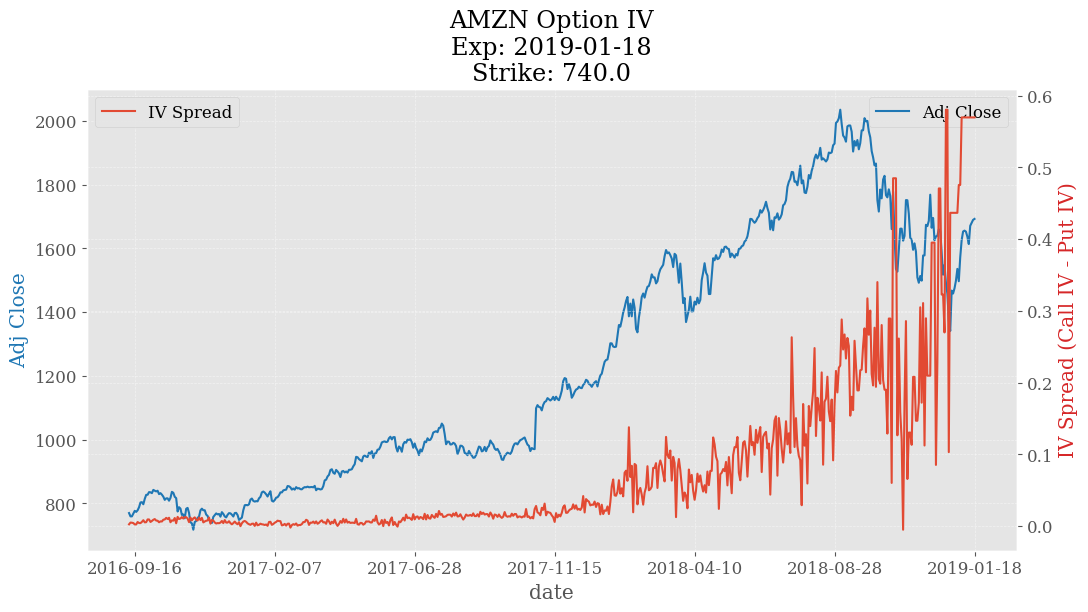

In [ ]:
PlotDynamics.plot_dual_axis_timeseries(
    iv_spread_df.index,
    [prices[(prices.index >= iv_spread_df.index.min()) & (prices.index <= iv_spread_df.index.max())]['adj_close'] * 20],
    [iv_spread_df['iv_spread']],
    ['Adj Close'],
    ['IV Spread'],
    xlabel='date',
    y1label='Adj Close',
    y2label='IV Spread (Call IV - Put IV)',
    title=f'AMZN Option IV\nExp: {r_exdate}\nStrike: {r_strike_price/1000}',
    xaxisfreq=6,
)

#### Random Option Time Series and IV Spread
***

2460000
2021-01-15


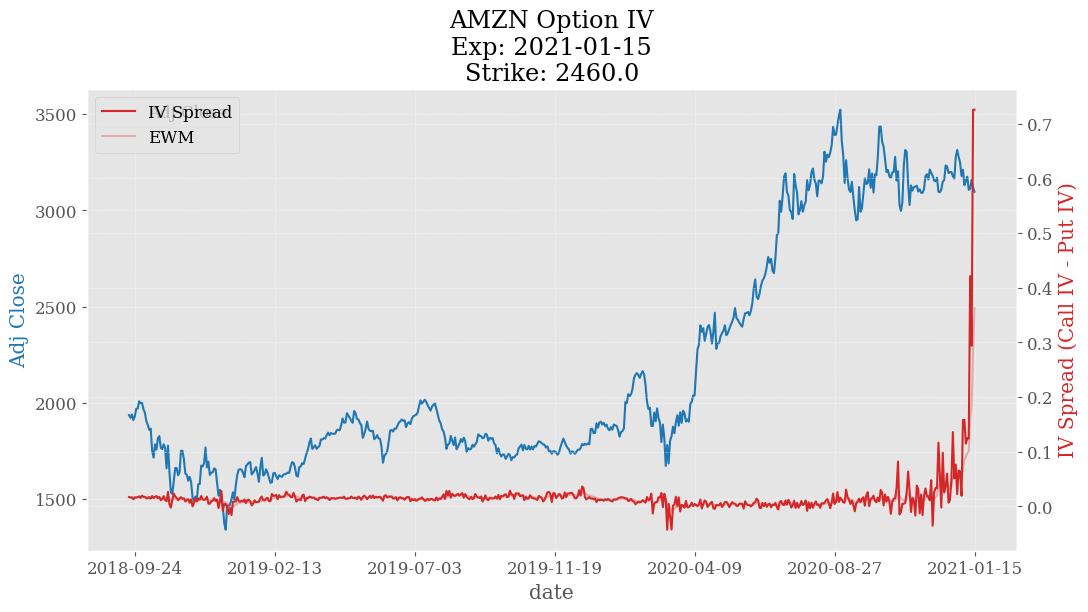

In [ ]:
random_row = amzn_df.sample(1)
r_strike_price = random_row['strike_price'].iloc[0]
r_exdate = random_row['exdate'].iloc[0]
# print(r_strike_price)
# print(r_exdate)

iv_spread_df = amzn_df[(amzn_df['exdate'] == f'{r_exdate}') & (amzn_df['strike_price'] == r_strike_price)].set_index(['date', 'cp_flag'])
iv_spread_data = {
    'date': [],
    'iv_spread': []
}
for date in sorted(iv_spread_df.index.get_level_values('date').unique()):
    iv_spread_data['date'].append(date)
    call_iv = iv_spread_df.loc[(date, 'C'), 'impl_volatility']
    put_iv = iv_spread_df.loc[(date, 'P'), 'impl_volatility']
    iv_spread_data['iv_spread'].append(call_iv - put_iv)

iv_spread_df = pd.DataFrame(iv_spread_data).ffill().set_index('date')

PlotDynamics.plot_dual_axis_timeseries(
    iv_spread_df.index,
    [prices[(prices.index >= iv_spread_df.index.min()) & (prices.index <= iv_spread_df.index.max())]['adj_close'] * 20],
    [
        iv_spread_df['iv_spread'],
        iv_spread_df['iv_spread'].ewm(span=10, adjust=False).mean()
    ],
    ['Adj Close'],
    ['IV Spread', 'EWM'],
    xlabel='date',
    y1label='Adj Close',
    y2label='IV Spread (Call IV - Put IV)',
    title=f'AMZN Option IV\nExp: {r_exdate}\nStrike: {r_strike_price/1000}',
    xaxisfreq=6,
    alpha=[1,1,0.3]
)